In [1]:
import sys  
sys.path.insert(0, '/Users/navinlr/Desktop/Thesis/code_base/conversation_quality')

In [2]:
from dataset_creation import dataset_creator as data_generator
from feature_extract import turntake_extractor as feat_extractor
import constants

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set(rc={'figure.figsize':(11.7,8.27)})

Total Groups = 115


In [3]:
# TEST Variables
agreeability_thresh=.2
annotators=["Divya", "Nakul"]#, "Swathi"]
zero_mean = False
from_store= False
filter_missing_data=True
transform_features=False
indiv_missing_data=['1_018_35', '2_006_15', '2_006_33', '2_011_29', '2_036_35', '2_044_8', '2_044_30', '3_004_37', '3_007_11', '3_052_27', '3_052_28', '3_058_25', '3_060_1', '3_068_15']
group_missing_data=['1_018', '2_006', '2_006', '2_011', '2_036', '2_044', '2_044', '3_004', '3_007', '3_052', '3_052', '3_058', '3_060', '3_068']

manifest="indiv"
if manifest == "indiv":
    features = ["conv_eq", "#turns", "%talk", "mean_turn", "mean_silence", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]
    store_file=constants.indiv_tt_X_path
    missing_data=indiv_missing_data
else:
    features = ["var_#turn", "var_dturn", "conv_eq", "mean_silence", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]
    store_file=constants.group_tt_X_path
    missing_data=group_missing_data

In [4]:
# Annotation Reader
reliable_ids, reliable_convqs, reliable_kappas = data_generator.get_annotation_realiable_labels(agreeability_thresh, manifest, annotators, zero_mean)
print("Total Groups in Analysis - " + str(len(reliable_ids)))

ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False
Total Groups in Analysis - 273


In [5]:
# Get Turn-Taking feaures for IDs (group/ indiv)
if from_store:
    tt_X = pd.read_csv(store_file, sep=',', header=None).values
#     tt_X.columns = features
#     tt_X.set_index(reliable_ids)
else:
    tt_X = feat_extractor.get_tt_dataset_feats_for(reliable_ids, features, manifest)

  0%|          | 0/273 [00:00<?, ?it/s]

For Sample ->>>> 1_005_13


  0%|          | 1/273 [00:01<04:37,  1.02s/it]

For Sample ->>>> 1_005_22


  1%|          | 2/273 [00:02<04:34,  1.01s/it]

For Sample ->>>> 1_018_20


  1%|          | 3/273 [00:03<04:31,  1.01s/it]

For Sample ->>>> 1_018_31


  1%|▏         | 4/273 [00:03<04:28,  1.00it/s]

For Sample ->>>> 1_018_35


  2%|▏         | 5/273 [00:04<04:26,  1.00it/s]

For Sample ->>>> 1_019_17


  2%|▏         | 6/273 [00:05<04:25,  1.01it/s]

For Sample ->>>> 1_019_25


  3%|▎         | 7/273 [00:06<04:25,  1.00it/s]

For Sample ->>>> 1_030_17


  3%|▎         | 8/273 [00:07<04:24,  1.00it/s]

For Sample ->>>> 1_030_28


  3%|▎         | 9/273 [00:08<04:23,  1.00it/s]

For Sample ->>>> 1_033_13


  4%|▎         | 10/273 [00:09<04:23,  1.00s/it]

For Sample ->>>> 1_033_22


  4%|▍         | 11/273 [00:10<04:21,  1.00it/s]

For Sample ->>>> 1_033_36


  4%|▍         | 12/273 [00:11<04:19,  1.00it/s]

For Sample ->>>> 1_034_17


  5%|▍         | 13/273 [00:13<04:43,  1.09s/it]

For Sample ->>>> 1_034_19


  5%|▌         | 14/273 [00:14<05:00,  1.16s/it]

For Sample ->>>> 1_034_25


  5%|▌         | 15/273 [00:15<05:11,  1.21s/it]

For Sample ->>>> 1_034_28


  6%|▌         | 16/273 [00:17<05:17,  1.24s/it]

For Sample ->>>> 1_035_12


  6%|▌         | 17/273 [00:18<05:22,  1.26s/it]

For Sample ->>>> 1_035_13


  7%|▋         | 18/273 [00:19<05:25,  1.28s/it]

For Sample ->>>> 1_035_22


  7%|▋         | 19/273 [00:21<05:27,  1.29s/it]

For Sample ->>>> 1_042_16


  7%|▋         | 20/273 [00:22<05:03,  1.20s/it]

For Sample ->>>> 1_042_18


  8%|▊         | 21/273 [00:23<04:46,  1.14s/it]

For Sample ->>>> 1_044_3


  8%|▊         | 22/273 [00:23<04:10,  1.00it/s]

For Sample ->>>> 1_044_22


  8%|▊         | 23/273 [00:24<03:44,  1.11it/s]

For Sample ->>>> 1_046_12


  9%|▉         | 24/273 [00:25<03:51,  1.08it/s]

For Sample ->>>> 1_046_13


  9%|▉         | 25/273 [00:26<03:54,  1.06it/s]

For Sample ->>>> 1_046_36


 10%|▉         | 26/273 [00:27<03:57,  1.04it/s]

For Sample ->>>> 1_047_12


 10%|▉         | 27/273 [00:28<03:34,  1.15it/s]

For Sample ->>>> 1_047_36


 10%|█         | 28/273 [00:28<03:18,  1.24it/s]

For Sample ->>>> 1_059_6


 11%|█         | 29/273 [00:29<03:06,  1.31it/s]

For Sample ->>>> 1_059_34


 11%|█         | 30/273 [00:30<02:58,  1.36it/s]

For Sample ->>>> 1_061_12


 11%|█▏        | 31/273 [00:31<03:16,  1.23it/s]

For Sample ->>>> 1_061_22


 12%|█▏        | 32/273 [00:32<03:29,  1.15it/s]

For Sample ->>>> 1_061_36


 12%|█▏        | 33/273 [00:33<03:36,  1.11it/s]

For Sample ->>>> 1_062_6


 12%|█▏        | 34/273 [00:34<04:28,  1.12s/it]

For Sample ->>>> 1_062_20


 13%|█▎        | 35/273 [00:36<05:04,  1.28s/it]

For Sample ->>>> 1_062_31


 13%|█▎        | 36/273 [00:38<05:29,  1.39s/it]

For Sample ->>>> 1_062_34


 14%|█▎        | 37/273 [00:39<05:46,  1.47s/it]

For Sample ->>>> 1_062_35


 14%|█▍        | 38/273 [00:41<05:58,  1.53s/it]

For Sample ->>>> 1_065_34


 14%|█▍        | 39/273 [00:42<04:56,  1.27s/it]

For Sample ->>>> 1_066_20


 15%|█▍        | 40/273 [00:42<04:36,  1.19s/it]

For Sample ->>>> 1_066_31


 15%|█▌        | 41/273 [00:43<04:20,  1.12s/it]

For Sample ->>>> 1_066_35


 15%|█▌        | 42/273 [00:44<04:10,  1.08s/it]

For Sample ->>>> 1_067_17


 16%|█▌        | 43/273 [00:46<04:24,  1.15s/it]

For Sample ->>>> 1_067_19


 16%|█▌        | 44/273 [00:47<04:35,  1.20s/it]

For Sample ->>>> 1_067_25


 16%|█▋        | 45/273 [00:48<04:41,  1.23s/it]

For Sample ->>>> 1_068_2


 17%|█▋        | 46/273 [00:50<04:45,  1.26s/it]

For Sample ->>>> 1_068_13


 17%|█▋        | 47/273 [00:51<04:48,  1.27s/it]

For Sample ->>>> 1_068_18


 18%|█▊        | 48/273 [00:52<04:48,  1.28s/it]

For Sample ->>>> 1_068_24


 18%|█▊        | 49/273 [00:54<04:50,  1.30s/it]

For Sample ->>>> 1_069_38


 18%|█▊        | 50/273 [00:54<04:07,  1.11s/it]

For Sample ->>>> 1_069_39


 19%|█▊        | 51/273 [00:55<03:36,  1.02it/s]

For Sample ->>>> 1_071_6


 19%|█▉        | 52/273 [00:57<04:19,  1.17s/it]

For Sample ->>>> 1_071_20


 19%|█▉        | 53/273 [00:58<04:47,  1.31s/it]

For Sample ->>>> 1_071_31


 20%|█▉        | 54/273 [01:00<05:18,  1.45s/it]

For Sample ->>>> 1_071_34


 20%|██        | 55/273 [01:02<06:14,  1.72s/it]

For Sample ->>>> 1_072_8


 21%|██        | 56/273 [01:03<05:17,  1.46s/it]

For Sample ->>>> 1_072_26


 21%|██        | 57/273 [01:04<04:25,  1.23s/it]

For Sample ->>>> 1_073_26


 21%|██        | 58/273 [01:05<03:48,  1.06s/it]

For Sample ->>>> 1_074_8


 22%|██▏       | 59/273 [01:05<03:21,  1.06it/s]

For Sample ->>>> 1_075_8


 22%|██▏       | 60/273 [01:06<03:02,  1.17it/s]

For Sample ->>>> 1_075_26


 22%|██▏       | 61/273 [01:07<02:49,  1.25it/s]

For Sample ->>>> 1_076_14


 23%|██▎       | 62/273 [01:07<02:40,  1.31it/s]

For Sample ->>>> 1_076_32


 23%|██▎       | 63/273 [01:08<02:33,  1.37it/s]

For Sample ->>>> 1_077_14


 23%|██▎       | 64/273 [01:09<02:29,  1.39it/s]

For Sample ->>>> 1_077_32


 24%|██▍       | 65/273 [01:09<02:26,  1.42it/s]

For Sample ->>>> 1_078_14


 24%|██▍       | 66/273 [01:10<02:22,  1.45it/s]

For Sample ->>>> 1_078_32


 25%|██▍       | 67/273 [01:11<02:20,  1.46it/s]

For Sample ->>>> 1_079_14


 25%|██▍       | 68/273 [01:11<02:18,  1.48it/s]

For Sample ->>>> 1_079_32


 25%|██▌       | 69/273 [01:12<02:17,  1.48it/s]

For Sample ->>>> 1_080_16


 26%|██▌       | 70/273 [01:13<02:16,  1.49it/s]

For Sample ->>>> 1_080_21


 26%|██▌       | 71/273 [01:13<02:15,  1.49it/s]

For Sample ->>>> 1_081_16


 26%|██▋       | 72/273 [01:14<02:14,  1.49it/s]

For Sample ->>>> 1_081_21


 27%|██▋       | 73/273 [01:15<02:15,  1.48it/s]

For Sample ->>>> 1_082_18


 27%|██▋       | 74/273 [01:15<02:17,  1.44it/s]

For Sample ->>>> 1_083_2


 27%|██▋       | 75/273 [01:16<02:15,  1.46it/s]

For Sample ->>>> 1_083_18


 28%|██▊       | 76/273 [01:17<02:13,  1.47it/s]

For Sample ->>>> 1_084_16


 28%|██▊       | 77/273 [01:17<02:15,  1.44it/s]

For Sample ->>>> 1_084_21


 29%|██▊       | 78/273 [01:18<02:19,  1.40it/s]

For Sample ->>>> 1_085_16


 29%|██▉       | 79/273 [01:19<02:20,  1.38it/s]

For Sample ->>>> 1_085_21


 29%|██▉       | 80/273 [01:20<02:19,  1.38it/s]

For Sample ->>>> 1_086_20


 30%|██▉       | 81/273 [01:21<02:52,  1.11it/s]

For Sample ->>>> 1_086_31


 30%|███       | 82/273 [01:22<03:17,  1.03s/it]

For Sample ->>>> 1_086_34


 30%|███       | 83/273 [01:24<03:32,  1.12s/it]

For Sample ->>>> 1_086_35


 31%|███       | 84/273 [01:25<03:43,  1.18s/it]

For Sample ->>>> 1_087_20


 31%|███       | 85/273 [01:26<03:50,  1.23s/it]

For Sample ->>>> 1_087_31


 32%|███▏      | 86/273 [01:28<03:55,  1.26s/it]

For Sample ->>>> 1_087_34


 32%|███▏      | 87/273 [01:29<03:56,  1.27s/it]

For Sample ->>>> 1_087_35


 32%|███▏      | 88/273 [01:30<03:58,  1.29s/it]

For Sample ->>>> 1_088_12


 33%|███▎      | 89/273 [01:31<03:22,  1.10s/it]

For Sample ->>>> 1_088_36


 33%|███▎      | 90/273 [01:32<02:58,  1.02it/s]

For Sample ->>>> 1_089_2


 33%|███▎      | 91/273 [01:33<02:58,  1.02it/s]

For Sample ->>>> 1_089_13


 34%|███▎      | 92/273 [01:34<02:58,  1.01it/s]

For Sample ->>>> 1_089_18


 34%|███▍      | 93/273 [01:35<02:57,  1.01it/s]

For Sample ->>>> 1_090_19


 34%|███▍      | 94/273 [01:35<02:39,  1.12it/s]

For Sample ->>>> 1_090_25


 35%|███▍      | 95/273 [01:36<02:26,  1.21it/s]

For Sample ->>>> 1_091_17


 35%|███▌      | 96/273 [01:37<02:17,  1.29it/s]

For Sample ->>>> 1_091_28


 36%|███▌      | 97/273 [01:37<02:10,  1.35it/s]

For Sample ->>>> 2_005_36


 36%|███▌      | 98/273 [01:39<02:58,  1.02s/it]

For Sample ->>>> 2_006_10


 36%|███▋      | 99/273 [01:41<03:49,  1.32s/it]

For Sample ->>>> 2_006_12


 37%|███▋      | 100/273 [01:43<04:26,  1.54s/it]

For Sample ->>>> 2_006_15


 37%|███▋      | 101/273 [01:45<04:50,  1.69s/it]

For Sample ->>>> 2_006_33


 37%|███▋      | 102/273 [01:47<05:05,  1.79s/it]

For Sample ->>>> 2_006_37


 38%|███▊      | 103/273 [01:49<05:31,  1.95s/it]

For Sample ->>>> 2_009_23


 38%|███▊      | 104/273 [01:50<04:32,  1.61s/it]

For Sample ->>>> 2_011_29


 38%|███▊      | 105/273 [01:51<04:12,  1.50s/it]

For Sample ->>>> 2_022_10


 39%|███▉      | 106/273 [01:53<03:50,  1.38s/it]

For Sample ->>>> 2_022_12


 39%|███▉      | 107/273 [01:54<03:34,  1.29s/it]

For Sample ->>>> 2_022_33


 40%|███▉      | 108/273 [01:55<03:21,  1.22s/it]

For Sample ->>>> 2_027_27


 40%|███▉      | 109/273 [01:55<02:52,  1.05s/it]

For Sample ->>>> 2_027_37


 40%|████      | 110/273 [01:56<02:34,  1.05it/s]

For Sample ->>>> 2_036_8


 41%|████      | 111/273 [01:58<03:23,  1.25s/it]

For Sample ->>>> 2_036_9


 41%|████      | 112/273 [02:00<03:56,  1.47s/it]

For Sample ->>>> 2_036_14


 41%|████▏     | 113/273 [02:02<04:18,  1.62s/it]

For Sample ->>>> 2_036_16


 42%|████▏     | 114/273 [02:04<04:33,  1.72s/it]

For Sample ->>>> 2_036_22


 42%|████▏     | 115/273 [02:06<04:44,  1.80s/it]

For Sample ->>>> 2_036_35


 42%|████▏     | 116/273 [02:08<04:49,  1.85s/it]

For Sample ->>>> 2_038_10


 43%|████▎     | 117/273 [02:09<04:07,  1.59s/it]

For Sample ->>>> 2_038_12


 43%|████▎     | 118/273 [02:10<03:38,  1.41s/it]

For Sample ->>>> 2_038_33


 44%|████▎     | 119/273 [02:11<03:17,  1.28s/it]

For Sample ->>>> 2_042_2


 44%|████▍     | 120/273 [02:12<03:32,  1.39s/it]

For Sample ->>>> 2_042_7


 44%|████▍     | 121/273 [02:14<03:42,  1.46s/it]

For Sample ->>>> 2_042_13


 45%|████▍     | 122/273 [02:16<03:48,  1.51s/it]

For Sample ->>>> 2_042_15


 45%|████▌     | 123/273 [02:17<03:52,  1.55s/it]

For Sample ->>>> 2_043_31


 45%|████▌     | 124/273 [02:18<03:25,  1.38s/it]

For Sample ->>>> 2_043_32


 46%|████▌     | 125/273 [02:19<03:07,  1.26s/it]

For Sample ->>>> 2_044_8


 46%|████▌     | 126/273 [02:21<03:36,  1.47s/it]

For Sample ->>>> 2_044_9


 47%|████▋     | 127/273 [02:23<03:57,  1.62s/it]

For Sample ->>>> 2_044_14


 47%|████▋     | 128/273 [02:25<04:11,  1.73s/it]

For Sample ->>>> 2_044_16


 47%|████▋     | 129/273 [02:27<04:31,  1.88s/it]

For Sample ->>>> 2_044_22


 48%|████▊     | 130/273 [02:29<04:32,  1.91s/it]

For Sample ->>>> 2_044_30


 48%|████▊     | 131/273 [02:31<04:33,  1.93s/it]

For Sample ->>>> 2_050_1


 48%|████▊     | 132/273 [02:32<03:51,  1.64s/it]

For Sample ->>>> 2_050_10


 49%|████▊     | 133/273 [02:33<03:23,  1.45s/it]

For Sample ->>>> 2_050_26


 49%|████▉     | 134/273 [02:34<03:02,  1.31s/it]

For Sample ->>>> 2_052_12


 49%|████▉     | 135/273 [02:36<03:01,  1.32s/it]

For Sample ->>>> 2_052_13


 50%|████▉     | 136/273 [02:37<03:00,  1.32s/it]

For Sample ->>>> 2_052_21


 50%|█████     | 137/273 [02:38<02:58,  1.31s/it]

For Sample ->>>> 2_056_27


 51%|█████     | 138/273 [02:39<02:44,  1.22s/it]

For Sample ->>>> 2_056_28


 51%|█████     | 139/273 [02:40<02:34,  1.15s/it]

For Sample ->>>> 2_056_37


 51%|█████▏    | 140/273 [02:41<02:27,  1.11s/it]

For Sample ->>>> 2_057_27


 52%|█████▏    | 141/273 [02:42<02:21,  1.07s/it]

For Sample ->>>> 2_057_37


 52%|█████▏    | 142/273 [02:43<02:17,  1.05s/it]

For Sample ->>>> 2_058_5


 52%|█████▏    | 143/273 [02:44<02:01,  1.07it/s]

For Sample ->>>> 2_059_5


 53%|█████▎    | 144/273 [02:45<01:50,  1.16it/s]

For Sample ->>>> 2_060_9


 53%|█████▎    | 145/273 [02:47<02:45,  1.30s/it]

For Sample ->>>> 2_060_14


 53%|█████▎    | 146/273 [02:49<03:22,  1.59s/it]

For Sample ->>>> 2_060_22


 54%|█████▍    | 147/273 [02:52<04:03,  1.94s/it]

For Sample ->>>> 2_060_29


 54%|█████▍    | 148/273 [02:55<04:28,  2.15s/it]

For Sample ->>>> 2_060_35


 55%|█████▍    | 149/273 [02:57<04:49,  2.33s/it]

For Sample ->>>> 2_061_8


 55%|█████▍    | 150/273 [03:02<05:58,  2.91s/it]

For Sample ->>>> 2_061_9


 55%|█████▌    | 151/273 [03:04<05:35,  2.75s/it]

For Sample ->>>> 2_061_16


 56%|█████▌    | 152/273 [03:06<05:16,  2.61s/it]

For Sample ->>>> 2_061_22


 56%|█████▌    | 153/273 [03:09<05:09,  2.58s/it]

For Sample ->>>> 2_061_29


 56%|█████▋    | 154/273 [03:11<04:57,  2.50s/it]

For Sample ->>>> 2_062_5


 57%|█████▋    | 155/273 [03:12<03:49,  1.94s/it]

For Sample ->>>> 2_062_29


 57%|█████▋    | 156/273 [03:12<03:02,  1.56s/it]

For Sample ->>>> 2_063_5


 58%|█████▊    | 157/273 [03:13<02:29,  1.29s/it]

For Sample ->>>> 2_063_29


 58%|█████▊    | 158/273 [03:14<02:07,  1.11s/it]

For Sample ->>>> 2_064_2


 58%|█████▊    | 159/273 [03:16<02:26,  1.29s/it]

For Sample ->>>> 2_064_31


 59%|█████▊    | 160/273 [03:17<02:37,  1.39s/it]

For Sample ->>>> 2_064_32


 59%|█████▉    | 161/273 [03:19<02:43,  1.46s/it]

For Sample ->>>> 2_064_36


 59%|█████▉    | 162/273 [03:20<02:49,  1.53s/it]

For Sample ->>>> 2_065_2


 60%|█████▉    | 163/273 [03:22<02:51,  1.56s/it]

For Sample ->>>> 2_065_31


 60%|██████    | 164/273 [03:24<02:51,  1.58s/it]

For Sample ->>>> 2_066_13


 60%|██████    | 165/273 [03:25<02:37,  1.46s/it]

For Sample ->>>> 2_066_21


 61%|██████    | 166/273 [03:26<02:28,  1.39s/it]

For Sample ->>>> 2_067_13


 61%|██████    | 167/273 [03:28<02:29,  1.41s/it]

For Sample ->>>> 2_067_15


 62%|██████▏   | 168/273 [03:29<02:36,  1.49s/it]

For Sample ->>>> 2_067_21


 62%|██████▏   | 169/273 [03:31<02:27,  1.42s/it]

For Sample ->>>> 2_068_10


 62%|██████▏   | 170/273 [03:32<02:32,  1.48s/it]

For Sample ->>>> 2_068_12


 63%|██████▎   | 171/273 [03:34<02:39,  1.56s/it]

For Sample ->>>> 2_068_33


 63%|██████▎   | 172/273 [03:36<02:39,  1.58s/it]

For Sample ->>>> 2_068_37


 63%|██████▎   | 173/273 [03:37<02:37,  1.58s/it]

For Sample ->>>> 2_069_27


 64%|██████▎   | 174/273 [03:38<02:14,  1.36s/it]

For Sample ->>>> 2_069_28


 64%|██████▍   | 175/273 [03:39<01:54,  1.17s/it]

For Sample ->>>> 3_004_26


 64%|██████▍   | 176/273 [03:41<02:17,  1.42s/it]

For Sample ->>>> 3_004_27


 65%|██████▍   | 177/273 [03:43<02:31,  1.58s/it]

For Sample ->>>> 3_004_28


 65%|██████▌   | 178/273 [03:44<02:30,  1.59s/it]

For Sample ->>>> 3_004_37


 66%|██████▌   | 179/273 [03:47<02:50,  1.81s/it]

For Sample ->>>> 3_006_4


 66%|██████▌   | 180/273 [03:49<03:04,  1.98s/it]

For Sample ->>>> 3_006_9


 66%|██████▋   | 181/273 [03:51<03:04,  2.00s/it]

For Sample ->>>> 3_006_20


 67%|██████▋   | 182/273 [03:52<02:44,  1.81s/it]

For Sample ->>>> 3_006_23


 67%|██████▋   | 183/273 [03:54<02:35,  1.73s/it]

For Sample ->>>> 3_007_11


 67%|██████▋   | 184/273 [03:56<02:31,  1.70s/it]

For Sample ->>>> 3_007_12


 68%|██████▊   | 185/273 [03:57<02:29,  1.70s/it]

For Sample ->>>> 3_007_15


 68%|██████▊   | 186/273 [03:59<02:18,  1.60s/it]

For Sample ->>>> 3_010_13


 68%|██████▊   | 187/273 [03:59<01:58,  1.37s/it]

For Sample ->>>> 3_010_36


 69%|██████▉   | 188/273 [04:00<01:41,  1.20s/it]

For Sample ->>>> 3_012_14


 69%|██████▉   | 189/273 [04:02<01:50,  1.32s/it]

For Sample ->>>> 3_012_25


 70%|██████▉   | 190/273 [04:03<01:53,  1.37s/it]

For Sample ->>>> 3_016_2


 70%|██████▉   | 191/273 [04:04<01:38,  1.20s/it]

For Sample ->>>> 3_016_31


 70%|███████   | 192/273 [04:05<01:26,  1.07s/it]

For Sample ->>>> 3_021_20


 71%|███████   | 193/273 [04:06<01:27,  1.10s/it]

For Sample ->>>> 3_021_23


 71%|███████   | 194/273 [04:07<01:26,  1.10s/it]

For Sample ->>>> 3_023_26


 71%|███████▏  | 195/273 [04:08<01:16,  1.02it/s]

For Sample ->>>> 3_023_27


 72%|███████▏  | 196/273 [04:09<01:09,  1.11it/s]

For Sample ->>>> 3_027_2


 72%|███████▏  | 197/273 [04:09<01:03,  1.20it/s]

For Sample ->>>> 3_027_31


 73%|███████▎  | 198/273 [04:10<00:58,  1.28it/s]

For Sample ->>>> 3_028_13


 73%|███████▎  | 199/273 [04:11<00:55,  1.34it/s]

For Sample ->>>> 3_028_36


 73%|███████▎  | 200/273 [04:11<00:52,  1.39it/s]

For Sample ->>>> 3_029_9


 74%|███████▎  | 201/273 [04:13<01:04,  1.12it/s]

For Sample ->>>> 3_029_20


 74%|███████▍  | 202/273 [04:14<01:12,  1.02s/it]

For Sample ->>>> 3_029_23


 74%|███████▍  | 203/273 [04:15<01:17,  1.11s/it]

For Sample ->>>> 3_031_4


 75%|███████▍  | 204/273 [04:16<01:14,  1.07s/it]

For Sample ->>>> 3_031_20


 75%|███████▌  | 205/273 [04:17<01:11,  1.05s/it]

For Sample ->>>> 3_031_23


 75%|███████▌  | 206/273 [04:18<01:09,  1.03s/it]

For Sample ->>>> 3_033_2


 76%|███████▌  | 207/273 [04:19<01:07,  1.02s/it]

For Sample ->>>> 3_033_31


 76%|███████▌  | 208/273 [04:20<01:06,  1.02s/it]

For Sample ->>>> 3_035_4


 77%|███████▋  | 209/273 [04:21<01:11,  1.11s/it]

For Sample ->>>> 3_035_9


 77%|███████▋  | 210/273 [04:23<01:13,  1.17s/it]

For Sample ->>>> 3_035_20


 77%|███████▋  | 211/273 [04:24<01:14,  1.21s/it]

For Sample ->>>> 3_035_23


 78%|███████▊  | 212/273 [04:25<01:15,  1.24s/it]

For Sample ->>>> 3_037_4


 78%|███████▊  | 213/273 [04:26<01:10,  1.18s/it]

For Sample ->>>> 3_037_20


 78%|███████▊  | 214/273 [04:27<01:06,  1.12s/it]

For Sample ->>>> 3_037_23


 79%|███████▉  | 215/273 [04:28<01:02,  1.08s/it]

For Sample ->>>> 3_041_4


 79%|███████▉  | 216/273 [04:30<01:05,  1.15s/it]

For Sample ->>>> 3_041_9


 79%|███████▉  | 217/273 [04:31<01:06,  1.19s/it]

For Sample ->>>> 3_041_20


 80%|███████▉  | 218/273 [04:32<01:07,  1.23s/it]

For Sample ->>>> 3_041_23


 80%|████████  | 219/273 [04:34<01:07,  1.25s/it]

For Sample ->>>> 3_042_2


 81%|████████  | 220/273 [04:34<00:57,  1.08s/it]

For Sample ->>>> 3_042_31


 81%|████████  | 221/273 [04:35<00:49,  1.05it/s]

For Sample ->>>> 3_043_13


 81%|████████▏ | 222/273 [04:36<00:44,  1.15it/s]

For Sample ->>>> 3_043_36


 82%|████████▏ | 223/273 [04:36<00:40,  1.23it/s]

For Sample ->>>> 3_046_26


 82%|████████▏ | 224/273 [04:37<00:37,  1.30it/s]

For Sample ->>>> 3_046_27


 82%|████████▏ | 225/273 [04:38<00:35,  1.35it/s]

For Sample ->>>> 3_048_7


 83%|████████▎ | 226/273 [04:38<00:33,  1.39it/s]

For Sample ->>>> 3_048_24


 83%|████████▎ | 227/273 [04:39<00:32,  1.42it/s]

For Sample ->>>> 3_050_9


 84%|████████▎ | 228/273 [04:40<00:31,  1.45it/s]

For Sample ->>>> 3_050_20


 84%|████████▍ | 229/273 [04:40<00:30,  1.46it/s]

For Sample ->>>> 3_051_4


 84%|████████▍ | 230/273 [04:41<00:29,  1.48it/s]

For Sample ->>>> 3_051_23


 85%|████████▍ | 231/273 [04:42<00:29,  1.44it/s]

For Sample ->>>> 3_052_26


 85%|████████▍ | 232/273 [04:43<00:40,  1.01it/s]

For Sample ->>>> 3_052_27


 85%|████████▌ | 233/273 [04:45<00:46,  1.16s/it]

For Sample ->>>> 3_052_28


 86%|████████▌ | 234/273 [04:47<00:52,  1.34s/it]

For Sample ->>>> 3_054_13


 86%|████████▌ | 235/273 [04:47<00:44,  1.17s/it]

For Sample ->>>> 3_054_36


 86%|████████▋ | 236/273 [04:48<00:40,  1.09s/it]

For Sample ->>>> 3_055_2


 87%|████████▋ | 237/273 [04:50<00:43,  1.22s/it]

For Sample ->>>> 3_055_31


 87%|████████▋ | 238/273 [04:51<00:43,  1.25s/it]

For Sample ->>>> 3_055_36


 88%|████████▊ | 239/273 [04:53<00:43,  1.27s/it]

For Sample ->>>> 3_058_14


 88%|████████▊ | 240/273 [04:53<00:35,  1.09s/it]

For Sample ->>>> 3_058_25


 88%|████████▊ | 241/273 [04:54<00:30,  1.04it/s]

For Sample ->>>> 3_060_1


 89%|████████▊ | 242/273 [04:55<00:33,  1.07s/it]

For Sample ->>>> 3_060_5


 89%|████████▉ | 243/273 [04:57<00:34,  1.15s/it]

For Sample ->>>> 3_060_21


 89%|████████▉ | 244/273 [04:58<00:34,  1.20s/it]

For Sample ->>>> 3_060_22


 90%|████████▉ | 245/273 [04:59<00:34,  1.23s/it]

For Sample ->>>> 3_061_1


 90%|█████████ | 246/273 [05:00<00:34,  1.26s/it]

For Sample ->>>> 3_061_5


 90%|█████████ | 247/273 [05:02<00:33,  1.28s/it]

For Sample ->>>> 3_061_21


 91%|█████████ | 248/273 [05:03<00:32,  1.30s/it]

For Sample ->>>> 3_061_22


 91%|█████████ | 249/273 [05:04<00:31,  1.30s/it]

For Sample ->>>> 3_062_1


 92%|█████████▏| 250/273 [05:06<00:30,  1.32s/it]

For Sample ->>>> 3_062_5


 92%|█████████▏| 251/273 [05:07<00:29,  1.33s/it]

For Sample ->>>> 3_062_21


 92%|█████████▏| 252/273 [05:09<00:27,  1.33s/it]

For Sample ->>>> 3_062_22


 93%|█████████▎| 253/273 [05:10<00:26,  1.33s/it]

For Sample ->>>> 3_063_1


 93%|█████████▎| 254/273 [05:11<00:25,  1.33s/it]

For Sample ->>>> 3_063_5


 93%|█████████▎| 255/273 [05:12<00:23,  1.32s/it]

For Sample ->>>> 3_063_21


 94%|█████████▍| 256/273 [05:14<00:22,  1.32s/it]

For Sample ->>>> 3_063_22


 94%|█████████▍| 257/273 [05:15<00:21,  1.32s/it]

For Sample ->>>> 3_064_3


 95%|█████████▍| 258/273 [05:16<00:16,  1.12s/it]

For Sample ->>>> 3_064_29


 95%|█████████▍| 259/273 [05:16<00:13,  1.01it/s]

For Sample ->>>> 3_065_3


 95%|█████████▌| 260/273 [05:17<00:11,  1.12it/s]

For Sample ->>>> 3_065_29


 96%|█████████▌| 261/273 [05:18<00:09,  1.21it/s]

For Sample ->>>> 3_066_3


 96%|█████████▌| 262/273 [05:18<00:08,  1.28it/s]

For Sample ->>>> 3_066_29


 96%|█████████▋| 263/273 [05:19<00:07,  1.33it/s]

For Sample ->>>> 3_068_15


 97%|█████████▋| 264/273 [05:20<00:06,  1.38it/s]

For Sample ->>>> 3_069_15


 97%|█████████▋| 265/273 [05:20<00:05,  1.41it/s]

For Sample ->>>> 3_072_26


 97%|█████████▋| 266/273 [05:22<00:06,  1.12it/s]

For Sample ->>>> 3_072_27


 98%|█████████▊| 267/273 [05:23<00:06,  1.02s/it]

For Sample ->>>> 3_072_28


 98%|█████████▊| 268/273 [05:24<00:05,  1.11s/it]

For Sample ->>>> 3_072_37


 99%|█████████▊| 269/273 [05:26<00:04,  1.17s/it]

For Sample ->>>> 3_073_26


 99%|█████████▉| 270/273 [05:27<00:03,  1.21s/it]

For Sample ->>>> 3_073_27


 99%|█████████▉| 271/273 [05:28<00:02,  1.25s/it]

For Sample ->>>> 3_073_28


100%|█████████▉| 272/273 [05:30<00:01,  1.27s/it]

For Sample ->>>> 3_073_37


100%|██████████| 273/273 [05:31<00:00,  1.21s/it]


In [6]:
# Save Features
if not from_store:
    # Save Dataset -- tt_X
    np.savetxt(store_file, tt_X, delimiter=",")

In [7]:
# Transform Features
if transform_features:
    from sklearn.preprocessing import StandardScaler
    tt_X = StandardScaler().fit_transform(tt_X)
    reliable_convqs = StandardScaler().fit_transform(np.array(reliable_convqs).reshape(-1, 1))

In [8]:
#Dataset Prep
tt_X = pd.DataFrame(data=tt_X, index=reliable_ids, columns=features) 
tt_X["convq"] = reliable_convqs

In [9]:
#Filter Dataset - Remove Incompelete Data
print("Before Filter: Feature Set -> " + str(tt_X.shape))
if filter_missing_data:
    final_reliable_ids = [x for x in reliable_ids if x not in missing_data]
    tt_X = tt_X[tt_X.index.isin(final_reliable_ids)]
print("After Filter: Feature Set -> " + str(tt_X.shape))

Before Filter: Feature Set -> (273, 11)
After Filter: Feature Set -> (259, 11)


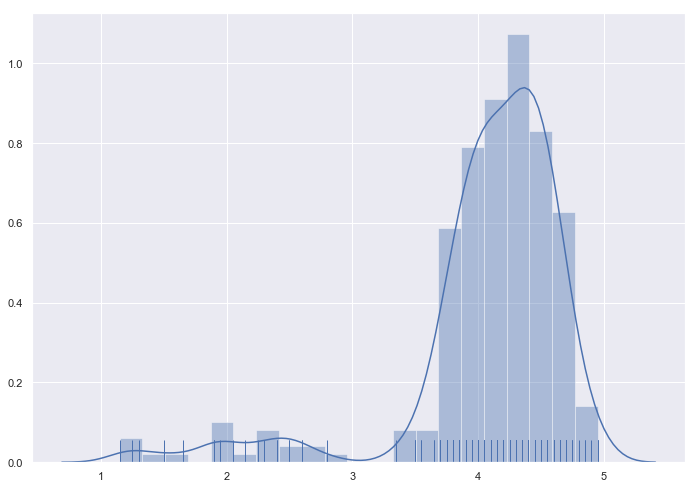

In [10]:
# Plots - Qualitative Analysis
sns.distplot(reliable_convqs, kde=True, rug=True)
plt.show()

In [11]:
# Statistical Tests:(Main Question)
# Do Turn-Taking features have a significant effect on the Perceived Individual's Experience of Conversation Quality?
# TT Features can be categorised into three categories -> Equality, Fluency and Synchronisation
#
# (Sub Question)
# Does Conversation Equality have a significant effect on the Perceived Individual's Experience of Conversation Quality?
#  1. Use Features "#turns", "%talk", "mean_turn". 
#
# (Sub Question)
# Does Conversation Fluency have a significant effect on the Perceived Individual's Experience of Conversation Quality?
# 1. Use Features "%silence", "mean_silence", "#bc". 
# 
# (Sub Question)
# Does Conversation Synchronisation have a significant effect on the Perceived Individual's Experience of Conversation Quality?
# 1. Use Features "%overlap", "#suc_interupt", "#un_interupt". 
# 
# For all above questions, after (1), perform below steps,
#  2. Fit a Quantile Least Square Regression model on the features vs the convq score.
#  3. Analyse p-value significance @ p<0.05
#  4. Check the co-efficients for informations.

In [12]:
test_feats=["const", "conv_eq", "#turns", "%talk", "mean_turn", "mean_silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]
conv_eq_feats=["const", "conv_eq"]
conv_fl_feats=["const", "%silence", "#bc"]
conv_sy_feats=["const", "%overlap", "#suc_interupt", "#un_interupt"]

test_feats=conv_eq_feats

In [13]:
# Experiment Below

# Ordinary Regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

X = sm.add_constant(tt_X)

model = sm.OLS(X["convq"], X.loc[:,test_feats])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  convq   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     24.02
Date:                Fri, 15 May 2020   Prob (F-statistic):           1.69e-06
Time:                        14:36:26   Log-Likelihood:                -251.03
No. Observations:                 259   AIC:                             506.1
Df Residuals:                     257   BIC:                             513.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0596      0.040    101.777      0.0

In [14]:
# Quantile Regression
X = sm.add_constant(tt_X)

model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,conv_eq_feats])
results = model.fit(q=.4)
print(results.summary())

model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,conv_fl_feats])
results = model.fit(q=.4)
print(results.summary())

model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,conv_sy_feats])
results = model.fit(q=.4)
print(results.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  convq   Pseudo R-squared:              0.05004
Model:                       QuantReg   Bandwidth:                      0.2812
Method:                 Least Squares   Sparsity:                        1.025
Date:                Fri, 15 May 2020   No. Observations:                  259
Time:                        14:36:26   Df Residuals:                      257
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0841      0.031    130.458      0.000       4.022       4.146
conv_eq        0.2220      0.048      4.644      0.000       0.128       0.316
                         QuantReg Regression Results                          
Dep. Variable:                  convq   Pseudo R-squ

In [15]:
# Generalised Linear Regression
X = sm.add_constant(tt_X)

model = sm.GLM(X["convq"], X.loc[:,test_feats])
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  convq   No. Observations:                  259
Model:                            GLM   Df Residuals:                      257
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.40996
Method:                          IRLS   Log-Likelihood:                -251.03
Date:                Fri, 15 May 2020   Deviance:                       105.36
Time:                        14:36:26   Pearson chi2:                     105.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0596      0.040    101.777      0.0